In [1]:
import sys

path='/home/tomas/Ulmer-Berechnung/alps2qutipplus-april/alps2qutipplus-main/'

sys.path.insert(1, path) 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qutip
import scipy.linalg as linalg
import time
from multiprocessing import Pool
from itertools import product
from typing import Optional

import alpsqutip.parallelized_functions_and_workers as plME

from alpsqutip import (build_system, list_models_in_alps_xml,
                       list_geometries_in_alps_xml, graph_from_alps_xml,
                       model_from_alps_xml,
                       restricted_maxent_toolkit as me)

from alpsqutip.operators.states.utils import safe_exp_and_normalize ## function used to safely and robustly map K-states to states

from alpsqutip.scalarprod import fetch_covar_scalar_product
from alpsqutip.operators.states.gibbs import GibbsDensityOperator, GibbsProductDensityOperator

In [3]:

from alpsqutip.operators.arithmetic import (
    ScalarOperator,
    LocalOperator,
    OneBodyOperator,
    Operator,
    ProductOperator,
    ScalarOperator,
    SumOperator,
    QutipOperator
)

from alpsqutip.operators.simplify import simplify_sum_operator

In [4]:
params={}

params['size']=7
params['Jx']=1.; params['Jy'] = .75*params['Jx']; params['Jz']=1.05*params['Jx']

from scipy.optimize import root, fsolve
Ffactor=np.real(max(np.roots(np.poly1d([1, 0, -(params['Jx']*params['Jy']+params['Jx']*params['Jy']+params['Jy']*params['Jz']), 
                           -2*params['Jx']*params['Jy']*params['Jz']]))))
chi_y=fsolve(lambda x,y: x*np.arcsinh(x)-np.sqrt(x**2+1)-y, 1e-1, args=(0))[0]
vLR=4*Ffactor*chi_y



In [5]:
from itertools import combinations
from functools import reduce

# Build system
system = build_system(geometry_name="open chain lattice", model_name="spin", 
                      L=params['size'], J=1)

sites = [s for s in system.sites]
sx_ops = [system.site_operator("Sx", f'1[{i}]') for i in range(len(sites))]
sy_ops = [system.site_operator("Sy", f'1[{i}]') for i in range(len(sites))]
sz_ops = [system.site_operator("Sz", f'1[{i}]') for i in range(len(sites))]

# Optional: full identity operator
idop = reduce(Operator.__mul__, [system.site_operator('identity@1[' + str(i) + ']') for i in range(len(sites))])

# XYZ nearest-neighbor Hamiltonian
H_XYZ = 0
for i in range(len(sites) - 1):  # Only nearest-neighbors
    H_XYZ += (
        params['Jx'] * sx_ops[i] * sx_ops[i+1] +
        params['Jy'] * sy_ops[i] * sy_ops[i+1] +
        params['Jz'] * sz_ops[i] * sz_ops[i+1]
    )

H_XYZ = H_XYZ.simplify()
H = H_XYZ

loading model spin  over graph open chain lattice


In [6]:
HBB0=[idop, sz_ops[3], H]


phi0 = np.array([.0, -3, .0])

K0 = me.k_state_from_phi_basis(phi0, HBB0)
sigma0 = GibbsDensityOperator(K0)
phi0[0] = np.log(sigma0.tr())
K0 = me.k_state_from_phi_basis(phi0, HBB0).simplify()
sigma0 = GibbsProductDensityOperator(K0)

timespan=np.linspace(.0, 500.1/vLR,800)
obs_SzA = sum(sz for sz in sz_ops)

[(sigma0.to_qutip() * op.to_qutip()).tr() for op in sz_ops] 

[3.8163916471489756e-17,
 6.591949208711867e-17,
 1.0755285551056204e-16,
 0.4525741268224336,
 0.0,
 0.0,
 0.0]

In [12]:
## exact dynamics
exact_K_at_timet=qutip.mesolve(H=H.to_qutip(), rho0=K0.to_qutip(), tlist=timespan)
exact_rho_at_timet=[safe_exp_and_normalize(-K_at_timeti)[0] for K_at_timeti in exact_K_at_timet.states]

evs_obs_ex=[qutip.expect(rho_at_timeti, obs_SzA.to_qutip()) for rho_at_timeti in exact_rho_at_timet]

In [19]:
simulations={}
tgt_obs = obs_SzA
sp_local = fetch_covar_scalar_product(sigma0)

from scipy.linalg import cho_solve, cho_factor
       
simulations[1] = {
    "parms":{
    "chosen_depth": 6,
    "m0": 3,
    "eps": 1e-6,
    },
  "saved_cut_times_index_ell":[0],
   "no_acts_ell" : [0],
    "local_bound_error_ell":[],
    "spectral_norm_Hij_tensor_ell":[],
    "instantaneous_w_errors":[],
} 

current_simulation = simulations[1]
current_simulation_parms = current_simulation["parms"]
chosen_depth = current_simulation_parms["chosen_depth"]
eps_tol = current_simulation_parms["eps"]
m0 = current_simulation_parms["m0"]

In [20]:
local_bound_error_ell = []
simulations[1]["evs"] = [(sigma0 * tgt_obs).tr()]  # initial observable expectation

sp_local = fetch_covar_scalar_product(sigma=sigma0)
sigma_act = sigma0
local_t_value = 0.0

# Initial bass construction and orthogonalization
HBB_ell_act = plME.parallelized_real_time_projection_of_hierarchical_basis(
    generator=H,
    seed_op=K0+1e-10*H,
    sigma_ref=sigma_act,
    m_max=m0,
    deep=chosen_depth,
    num_workers=10,
    chunksize=30
)

Gram_matrix_act = plME.parallel_gram_matrix_process(basis = HBB_ell_act, 
                                           sp = sp_local,
                                           num_workers=8,
                                           chunksize = 30)
R_act = np.linalg.cholesky(Gram_matrix_act).conj().T

b_orth= linalg.inv(R_act.T) @ HBB_ell_act

Hij_tensor_act_non_orth = plME.compute_Hij_tensor_non_orth(
    basis = HBB_ell_act, 
    generator = H, 
    sp = sp_local,
    sigma_ref = sigma0,
    m_max = m0,
    Gram = Gram_matrix_act,
            num_workers=10,
    chunksize = 30
)

Hij_tensor_act = (linalg.inv(R_act).T 
                  @ Hij_tensor_act_non_orth 
                  @ linalg.inv(R_act)) ### In this convention for R_act, the orthonormal Hij_orth is
                                       ### Hij_orth = (R**-1).T @ Hij_non_orth @ (R**-1)

phi0_proj_act = np.array([sp_local(K0, op) for op in b_orth])
new_obs_local=sum(phi0a * opa for phi0a, opa in zip(phi0_proj_act, b_orth)).simplify()
print("Fita: Check", ((new_obs_local.to_qutip() - K0.to_qutip())).norm())

for t in timespan[1:]:
    start = time.time()
    
    delta_t = t - local_t_value
    exp_H = linalg.expm(delta_t * Hij_tensor_act)
    phi_local = np.real(exp_H @ phi0_proj_act)
    
    print(f"A. phi-local {time.time() - start:.2f}s");    start = time.time()
    
    K_local = (phi_local @ b_orth).simplify()
    #b_orth=None; HBB_ell_act = None
    
    print(f"B. obs-local {time.time() - start:.2f}s");    start = time.time()
        
    simulations[1]["evs"].append((GibbsDensityOperator(K_local)*tgt_obs).tr()) ### the minus is here
    
    print(f"C. Ev {time.time() - start:.2f}s");    start = time.time()
    
    # Compute the local bound error ratio
    numerator = me.m_th_partial_sum(phi=phi_local, m=2)
    denominator = me.m_th_partial_sum(phi=phi_local, m=0)
    local_bound_error_ell.append(numerator / denominator)
    
    # Check if error is above threshold, trigger basis update
    if abs(local_bound_error_ell[-1]) >= eps_tol:
        local_t_value = t
        print(f"a. Renormalization at t={list(timespan).index(t)}")
        
        print("a. start t=", list(timespan).index(t))
        if list(timespan).index(t)%5==0:
            K_act=plME._projection_worker(operator=(K_local.as_sum_of_products(), 1, sigma_act))
            sigma_act=GibbsProductDensityOperator(K_act)
            sp_local = fetch_covar_scalar_product(sigma_act)
        
        start = time.time()
        HBB_ell_act = plME.parallelized_real_time_projection_of_hierarchical_basis(
                generator=H,
                seed_op=K_local,
                sigma_ref=sigma_act,
                m_max=m0,
                deep=chosen_depth,
                num_workers=10,
                chunksize=30
        )
        print(f"b. HBB_ell_act, {time.time() - start:.6f}s")
        
        start = time.time()
        
        Gram_matrix_act = plME.parallel_gram_matrix_process(basis = HBB_ell_act, 
                                           sp = sp_local,
                                           num_workers=8,
                                            chunksize = 30)
        
        R_act = np.linalg.cholesky(Gram_matrix_act).conj().T

        b_orth= linalg.inv(R_act.T) @ HBB_ell_act

        print(f"c. orth basis act, {time.time() - start:.6f}s")
        
        start = time.time()
        
        Hij_tensor_act_non_orth = plME.compute_Hij_tensor_non_orth(
            basis = HBB_ell_act, 
            generator = H, 
            sp = sp_local,
            sigma_ref = sigma_act,
            m_max = m0,
            Gram = Gram_matrix_act,
            num_workers=10,
            chunksize = 30
        )
            
        print(f"d. Hij-tensor-act, {time.time() - start:.6f}s")
        Hij_tensor_act = linalg.inv(R_act).T @ Hij_tensor_act_non_orth @ linalg.inv(R_act)
        phi0_proj_act = np.array([sp_local(K_local, op) for op in b_orth])
        new_obs_local=sum(phi0a * opa for phi0a, opa in zip(phi0_proj_act, b_orth)).simplify()
        print("Fita: Check", ((K_local.to_qutip() - new_obs_local.to_qutip())).norm())
    else:
        # If error below tolerance, keep current basis and coefficients
        pass

Fita: Check 1.0832830921588718e-08
A. phi-local 0.00s
B. obs-local 0.01s
C. Ev 0.17s
A. phi-local 0.00s
B. obs-local 0.01s
C. Ev 0.06s
A. phi-local 0.00s
B. obs-local 0.02s
C. Ev 0.15s
A. phi-local 0.00s
B. obs-local 0.01s
C. Ev 0.05s
A. phi-local 0.00s
B. obs-local 0.01s
C. Ev 0.05s
A. phi-local 0.00s
B. obs-local 0.01s
C. Ev 0.06s
A. phi-local 0.00s
B. obs-local 0.02s
C. Ev 0.07s
a. Renormalization at t=7
a. start t= 7
b. HBB_ell_act, 39.058448s
c. orth basis act, 26.100317s
d. Hij-tensor-act, 22.666659s
Fita: Check 6.724893772866492e-14
A. phi-local 0.00s
B. obs-local 0.15s
C. Ev 0.06s
A. phi-local 0.00s
B. obs-local 0.07s
C. Ev 0.06s
A. phi-local 0.00s
B. obs-local 0.07s
C. Ev 0.06s
A. phi-local 0.00s
B. obs-local 0.08s
C. Ev 0.06s
A. phi-local 0.00s
B. obs-local 0.07s
C. Ev 0.05s
A. phi-local 0.00s
B. obs-local 0.07s
C. Ev 0.06s
A. phi-local 0.00s
B. obs-local 0.07s
C. Ev 0.05s
a. Renormalization at t=14
a. start t= 14
b. HBB_ell_act, 41.901138s
c. orth basis act, 29.139247s
d. Hi

Process ForkProcess-1095:
Process ForkProcess-1093:
Process ForkProcess-1094:
Process ForkProcess-1096:
Process ForkProcess-1092:
Process ForkProcess-1097:
Process ForkProcess-1098:
Process ForkProcess-1091:
Process ForkProcess-1090:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tomas/miniconda3/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/tomas/miniconda3/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/tomas/miniconda3/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/tomas/miniconda3/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.r

KeyboardInterrupt: 

  File "/home/tomas/miniconda3/lib/python3.12/concurrent/futures/process.py", line 252, in _process_worker
    call_item = call_queue.get(block=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tomas/miniconda3/lib/python3.12/multiprocessing/queues.py", line 102, in get
    with self._rlock:
         ^^^^^^^^^^^
  File "/home/tomas/miniconda3/lib/python3.12/multiprocessing/queues.py", line 102, in get
    with self._rlock:
         ^^^^^^^^^^^
  File "/home/tomas/miniconda3/lib/python3.12/multiprocessing/queues.py", line 103, in get
    res = self._recv_bytes()
          ^^^^^^^^^^^^^^^^^^
  File "/home/tomas/miniconda3/lib/python3.12/multiprocessing/queues.py", line 102, in get
    with self._rlock:
         ^^^^^^^^^^^
  File "/home/tomas/miniconda3/lib/python3.12/multiprocessing/queues.py", line 102, in get
    with self._rlock:
         ^^^^^^^^^^^
  File "/home/tomas/miniconda3/lib/python3.12/multiprocessing/synchronize.py", line 95, in __enter__
    return self._seml

/tmp/ipykernel_17734/2308323235.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


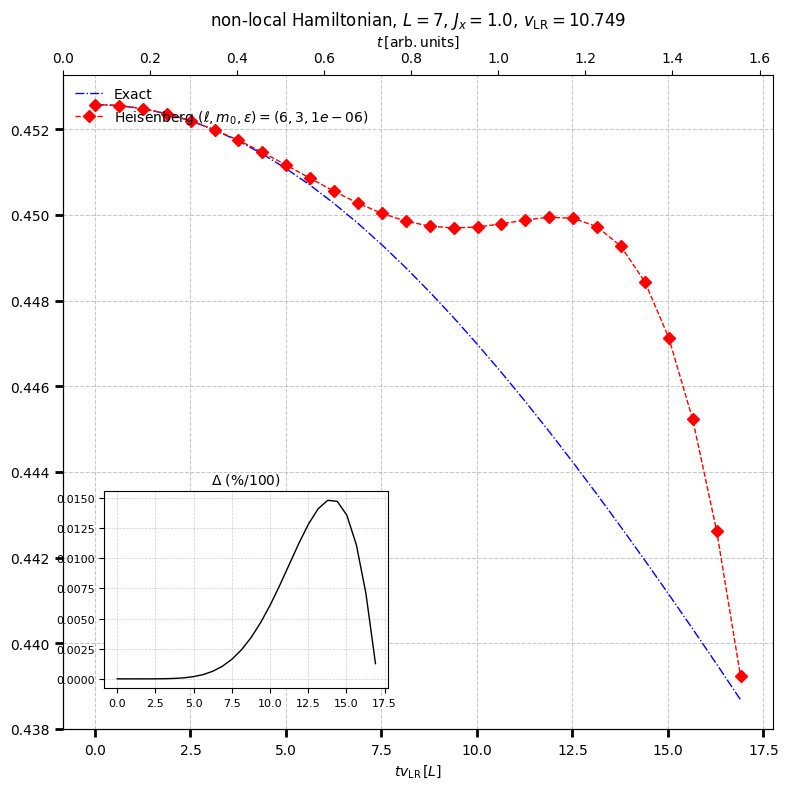

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Création de la figure et des axes principaux
fig, ax = plt.subplots(figsize=(8, 8))

n = 1
m = 28

# --- Courbe principale: observable exact + simulation ---
ax.plot(timespan[:m]*vLR, evs_obs_ex[:m],
        label='Exact', color="blue", linestyle='dashdot', linewidth=1)

l = simulations[1]["parms"]["chosen_depth"]
m0 = simulations[1]["parms"]["m0"]
eps = simulations[1]["parms"]["eps"]

label_sim1 = fr'Heisenberg $(\ell, m_0, \epsilon) = ({l}, {m0}, {eps})$'
ax.plot(timespan[:m]*vLR, simulations[1]["evs"][:m],
        label=label_sim1, color='red', linestyle='--', marker='D', linewidth=1)

# --- Inset: Delta courbe ---
weigthed_fidelity = np.array([abs(evs_obs_ex[i] - simulations[1]["evs"][i])/abs(evs_obs_ex[i])
                             for i in range(0, m)])
inset_ax = inset_axes(ax, width="40%", height="30%", loc='lower left', borderpad=3)
inset_ax.plot(timespan[:m]*vLR,weigthed_fidelity,
              color="black", linestyle='solid', linewidth=1)
inset_ax.set_title(r'$\Delta\ (\%/100)$', fontsize=10)

inset_ax.tick_params(labelsize=8)
inset_ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

# --- Style global ---
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(direction='out', length=6, width=2, which='major', grid_alpha=0.6)
ax.grid(True, which='major', linestyle='--', linewidth=0.75, alpha=0.7)
ax.legend(frameon=False, loc='upper left')

# Axe secondaire en haut
ax1 = ax.twiny()
ax1.set_xlim(timespan[0], timespan[m])
ax.set_xlabel(r'$t v_{\rm LR} \, [L]$')
ax1.set_xlabel(r'$t \, [{\rm arb. units}]$')

# Titre
plt.title(r'non-local Hamiltonian, $L={}$, $J_x={}$, $v_{{\rm LR}}={}$'.format(
    params['size'], 
    round(params['Jx'], 3), 
    round(vLR, 3)
))

plt.tight_layout()


In [ ]:
timespan

In [21]:
(0.116-0.110)/0.110

0.05454545454545459